**Important Libraries**

In [ ]:
!pip install torchinfo

In [ ]:
!pip install torchmetrics

In [ ]:
from google.colab import drive
from pathlib import Path
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from typing import Tuple, Dict, List
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights
from torchinfo import summary
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

**Checking GPU**

In [ ]:
!nvidia-smi

Tue Aug 22 04:17:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Mounting drive in google colab**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.empty_cache()


**Install kaggle and download kaggle dataset**

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s 'Brain MRI Images'

In [ ]:
!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-17-classes

In [ ]:
mkdir ~/brain_tumor_data

In [ ]:
!unzip brain-tumor-mri-images-17-classes.zip -d ~/brain_tumor_data

In [ ]:
image_data_path=Path("/root/brain_tumor_data")

**Create a function to scan the directory of imgaes**

In [ ]:
def directory_scan(directory_path):
    for dir_path, dir_names, file_names in os.walk(directory_path):
        print("There are", len(dir_names), "directories and", len(file_names), "images in", dir_path)

directory_scan(image_data_path)

**Visualizing an image from the directory**

random_image_path: /root/brain_tumor_data/Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2/glioma (150).jpeg
image_class: Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2
image_height: 630
image_width: 571


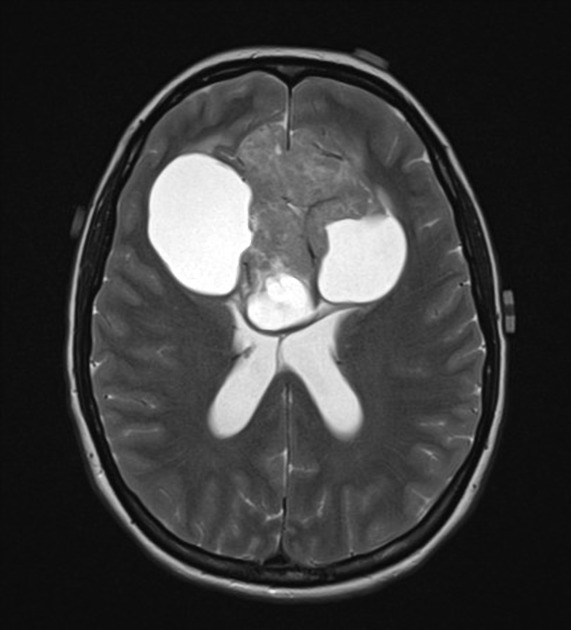

In [ ]:
#1.Get all image paths
img_paths_list=[path_name for i in [image_data_path.glob('*/*.%s' % ext) for ext in ["jpg","jpeg","png","webp"]] for path_name in i]


#2.Pick a random image path
random_img_path=random.choice(img_paths_list)

#3. Get image class from path name ( name of the directory in this case)
img_class=random_img_path.parent.stem

#4. Open the image using PIL
image=Image.open(random_img_path)


#5.Print image metadata
print("random_image_path:", random_img_path)
print("image_class:", img_class)
print("image_height:", image.height)
print("image_width:", image.width)

image

(-0.5, 570.5, 629.5, -0.5)

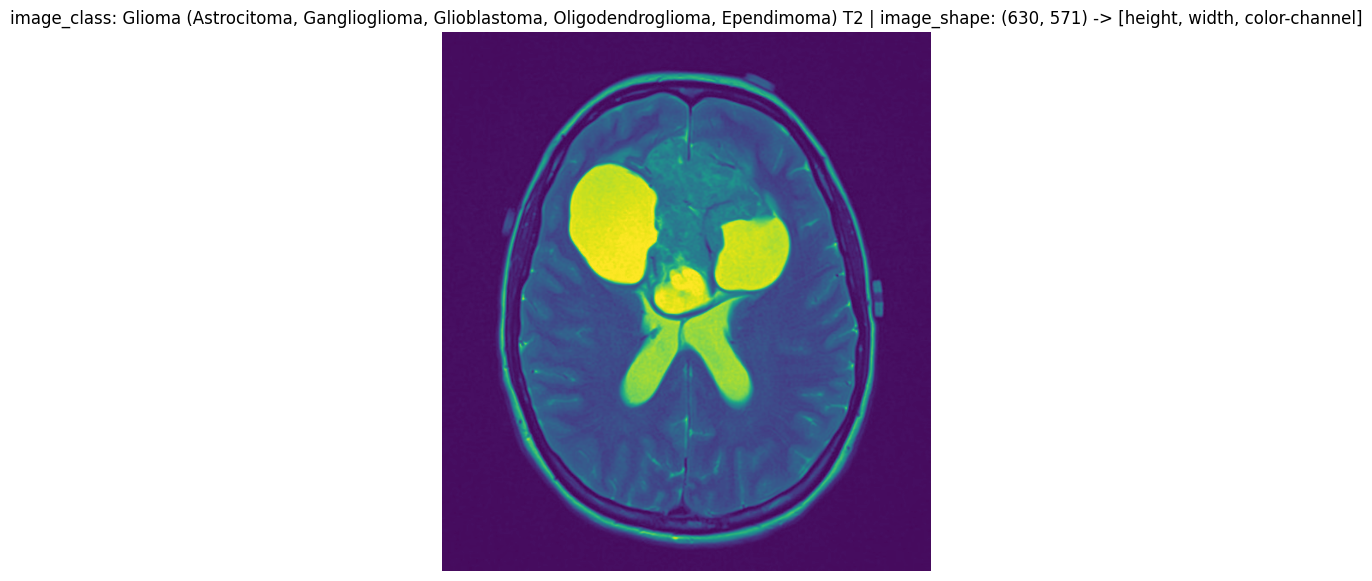

In [ ]:
#Turn the image into array
image_array=np.asarray(image)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(image_array)
plt.title(f"image_class: {img_class} | image_shape: {image_array.shape} -> [height, width, color-channel]")
plt.axis(False)

**Create an image tranform function to change the size and color channels of images**

In [ ]:
images_transform=transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

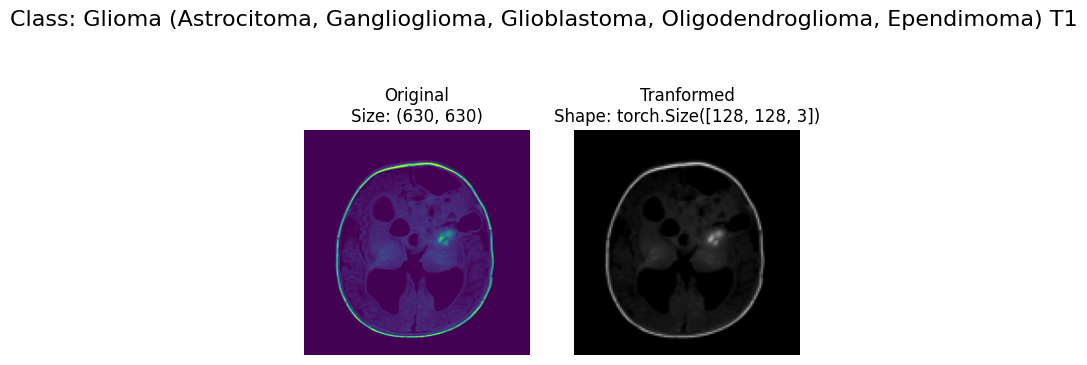

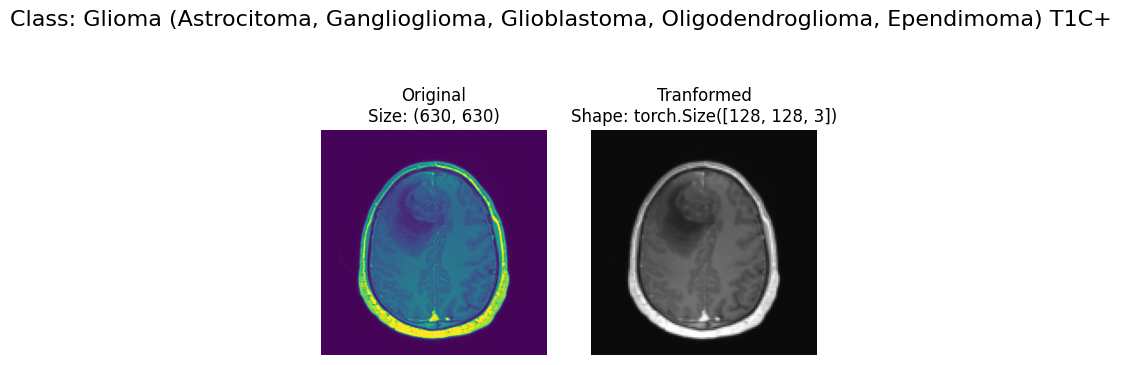

In [ ]:
def image_tranformation(img_paths: list, transform, n=2):
    random_img_paths=random.sample(img_paths, k=n)
    for img_path in random_img_paths:
        with Image.open(img_path) as f:
            fig, ax=plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)


            #Plot the transformed image

            trans_img=transform(f).permute(1, 2, 0) #we will need to change shape for matplotlib
            ax[1].imshow(trans_img)
            ax[1].set_title(f"Tranformed\nShape: {trans_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {img_path.parent.stem}", fontsize=16)

image_data_path=Path("/root/brain_tumor_data")

image_tranformation(
    img_paths= img_paths_list,
    transform=images_transform,
    n=2)

**Create a function for augmentation of images (to increase the number of samples)**

In [ ]:
class DataAugmentation(Dataset):
    def __init__(self, images, labels):
        # images
        self.X = images
        # labels
        self.y = labels

        # Transformation for converting original image array to an image and then convert it to a tensor
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
        # Transformation for converting original image array to an image, rotate it randomly between -45 degrees and 45 degrees, and then convert it to a tensor
        self.transform1 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(45),
            transforms.ToTensor()
        ])
        # Transformation for converting original image array to an image, rotate it randomly between -90 degrees and 90 degrees, and then convert it to a tensor
        self.transform2 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(90),
            transforms.ToTensor()
        ])

        # Transformation for converting original image array to an image, rotate it randomly between -120 degrees and 120 degrees, and then convert it to a tensor
        self.transform3 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(120),
            transforms.ToTensor()
        ])

        # Transformation for converting original image array to an image, rotate it randomly between -180 degrees and 180 degrees, and then convert it to a tensor
        self.transform4 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(180),
            transforms.ToTensor()
        ])

        # Transformation for converting original image array to an image, rotate it randomly between -270 degrees and 270 degrees, and then convert it to a tensor
        self.transform5 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(270),
            transforms.ToTensor()
        ])

        # Transformation for converting original image array to an image, rotate it randomly between -300 degrees and 300 degrees, and then convert it to a tensor
        self.transform6 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(300),
            transforms.ToTensor()
        ])

        # Transformation for converting original image array to an image, rotate it randomly between -330 degrees and 330 degrees, and then convert it to a tensor
        self.transform7 = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(330),
            transforms.ToTensor()
        ])

    def __len__(self):
        # return length of image samples
        return len(self.X)
    def __getitem__(self, idx):
        # perform transformations on one instance of X
        # Original image as a tensor
        data = self.transform(self.X[idx])

        # Augmented image at 45 degrees as a tensor
        aug45 = self.transform1(self.X[idx])

        # Augmented image at 90 degrees as a tensor
        aug90 = self.transform2(self.X[idx])

        # Augmented image at 120 degrees as a tensor
        aug120 = self.transform3(self.X[idx])

        # Augmented image at 180 degrees as a tensor
        aug180 = self.transform4(self.X[idx])

        # Augmented image at 270 degrees as a tensor
        aug270 = self.transform5(self.X[idx])

        # Augmented image at 300 degrees as a tensor
        aug300 = self.transform6(self.X[idx])

        # Augmented image at 330 degrees as a tensor
        aug330 = self.transform7(self.X[idx])

        # store the transformed images in a list

        new_batch = [data, aug45, aug90, aug120, aug180, aug270, aug300, aug330]

        # one-hot encode the labels

        labels = torch.zeros(17, dtype=torch.float32)
        labels[int(self.y[idx])] = 1.0



        new_labels = [labels, labels, labels, labels, labels, labels, labels, labels]

        # 8 augmented images and corresponding labels per sample will be returned
        return (torch.stack(new_labels), torch.stack(new_batch))

**Create a function to get the list of classes names and dictionary of classes with index**

In [ ]:
def get_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # Scan the images directory and find classes
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names does not exist
    if not classes:
        raise FileNotFoundError("No classes found in", directory)

    # 3. Create a dictionary of class indexes
    class_index = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_index

In [ ]:
get_classes(image_data_path)

(['Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1',
  'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+',
  'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2',
  'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1',
  'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+',
  'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2',
  'NORMAL T1',
  'NORMAL T2',
  'Neurocitoma (Central - Intraventricular, Extraventricular) T1',
  'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+',
  'Neurocitoma (Central - Intraventricular, Extraventricular) T2',
  'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1',
  'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+',
  'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2',
  'Schwannoma (Acustico, Vestibular - Trigeminal) T1',
 

**Create a function to create custom dataset**

In [ ]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, target_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = [item for i in [pathlib.Path(image_data_path).glob('*/*.%s' % ext) for ext in ["jpg","jpeg","png","webp"]] for item in i] # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_idx = get_classes(target_dir)

    # 4. Create function to load images
    def load_image(self, index: int) -> Image.Image:
        image_data_path = self.paths[index]
        return Image.open(image_data_path)

    # 5. Create __len__() method
    def __len__(self) -> int:
        return len(self.paths)

    # 6. Create __getitem__() method
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name
        class_idx = self.class_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [ ]:
import pathlib
total_image_data = ImageFolderCustom(target_dir=image_data_path,
                                     transform=images_transform)

len(total_image_data)

4448

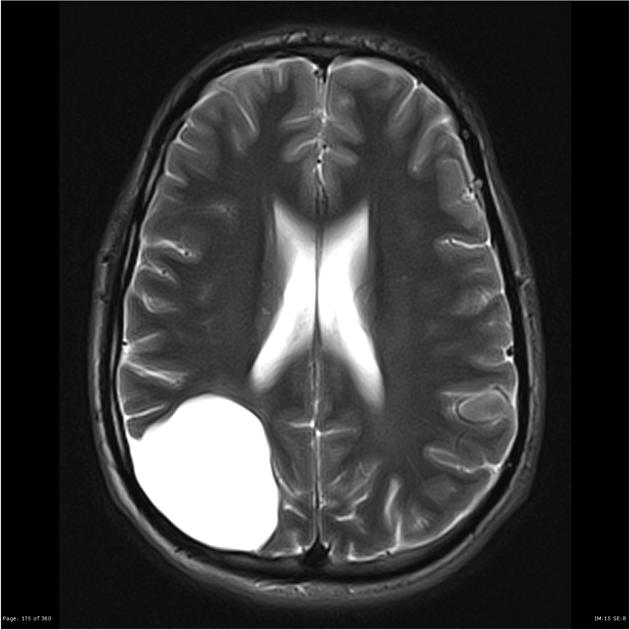

In [ ]:
total_image_data.load_image(0)

**Create empty lists for storing data**

In [ ]:
X_total = []
y_total = []
images = None
labels = None

**Store images and labels**

In [ ]:
for images,labels in total_image_data:
    X_total.append(images)
    y_total.append(labels)

**Split data into train, validation and test set**

In [ ]:
X_training, X_testing, y_training, y_testing = train_test_split(X_total,
                                                    y_total,
                                                    test_size=0.3003,
                                                    shuffle=True)
X_validation, X_testing, y_validation, y_testing = train_test_split(X_testing,
                                                    y_testing,
                                                    test_size=0.5029,
                                                    shuffle=True)

len(X_training), len(X_validation), len(X_testing)

(3112, 664, 672)

**Empty the lists and arrays to free up RAM**

In [ ]:
X_total = None
y_total = None
images = None
labels = None

**Create training set, validation set and testing set using DataAugmention funtion**

In [ ]:
training_set = DataAugmentation(X_training, y_training)
testing_set = DataAugmentation(X_testing, y_testing)
validation_set = DataAugmentation(X_validation, y_validation)


**Create a DataLoader for each set with batch size of 4 for train and validation set and batch size of 8 for test set**

In [ ]:
train_dataloader = DataLoader(dataset=training_set,
                              batch_size=4,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=testing_set,
                             batch_size=8,
                             num_workers=1,
                             shuffle=True)
valid_dataloader = DataLoader(dataset=validation_set,
                              batch_size=4,
                              num_workers=1,
                              shuffle=True)

train_dataloader, test_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7df213fb6860>,
 <torch.utils.data.dataloader.DataLoader at 0x7df213fb7520>)

**Set the device as GPU for training**

In [ ]:
device_name="cuda" if torch.cuda.is_available() else "cpu"
device=torch.device(device_name)
print(device)

cuda


**Build the model using resnet50 model**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet50:
    def __init__(self, num_classes, pretrained=True):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes
        self.pretrained = pretrained
        self.model = self._create_model()

    def _create_model(self):
        model = models.resnet50(pretrained=self.pretrained)

        # Set all parameters as trainable
        for param in model.parameters():
            param.requires_grad = True

        # Get input size of the fully connected layer
        inputs = model.fc.in_features

        # Redefine the fully connected (fc) layer for classification
        model.fc = nn.Sequential(
            nn.Linear(inputs, 2048),
            nn.SELU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.SELU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, self.num_classes),
            nn.LogSigmoid()
        )

        # Set all parameters of the model as trainable
        for name, child in model.named_children():
            for name2, params in child.named_parameters():
                params.requires_grad = True

        model.to(self.device)
        return model

    def get_model(self):
        return self.model

    def print_architecture(self):
        print(self.model)

# Instantiate the custom ResNet-50 model
num_classes = 17  # Number of classes for your classification problem
custom_resnet = CustomResNet50(num_classes=num_classes, pretrained=True)

# Get the model instance and print its architecture
model = custom_resnet.get_model()
print("Custom ResNet-50 Architecture:")
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 257MB/s]


Custom ResNet-50 Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, 

**Setup loss and optimizer**

In [ ]:
# create loss function
loss_fn = nn.CrossEntropyLoss().to(device)

#create optimizer
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=3e-4)


**Create a function to check training time**

In [ ]:
def training_time(start_time: float, end_time: float, device: torch.device = None):
    total_time = end_time - start_time
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

**Create empty lists to store losses and accuracies**

In [ ]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

**Train the model**

In [ ]:
# Set the seed and start the timer
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 40

# empty batch variables
batch = None
train_batch = None
val_batch = None

# Create training and testing loop
for i in tqdm(range(epochs)):
    # set empty training accuracy and validation accuracy
    train_acc, val_acc = 0, 0
    # Add a loop to loop through training batches
    for batch, (y, X) in enumerate(train_dataloader):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X.view(-1, 3, 128, 128))

        # 2. Calculate loss and accuracy
        train_loss = loss_fn(y_pred.float(), torch.argmax(y.view(32, 17), dim=1).long())

        train_acc += (torch.argmax(y_pred, dim=1).data==torch.argmax(y.view(32, 17), dim=1)).sum()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        train_loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Print out loss and accuracy
    print(f"Epoch: {i+1}\n-------")
    print(f"\nTrain loss: {train_loss.item():.4f}, Train acc: {train_acc.item()*100/(4*8*batch):.4f}%\n")

    # some metrics storage for visualization
    train_batch = batch
    train_loss_list.append(train_loss.detach())
    train_accuracy_list.append(train_acc.item()*100/(4*8*batch))

    X, y = None, None



    # Testing
    with torch.inference_mode():
        for batch, (y, X) in enumerate(valid_dataloader):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            val_pred = model(X.view(-1, 3, 128, 128))

            # 2. Calculate loss and accuracy
            val_loss=loss_fn(val_pred.float(), torch.argmax(y.view(32, 17), dim=1).long())

            val_acc += (torch.argmax(val_pred, dim=1).data==torch.argmax(y.view(32, 17), dim=1)).sum()


    ## Print out what's happening
    print(f"\nValidation loss: {val_loss.item():.4f}, Validation acc: {val_acc.item()*100/(4*8*batch):.4f}%\n")

    # some metrics storage for visualization
    val_batch =batch
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc.item()*100/(4*8*batch))

train_time_end_on_cpu = timer()
total_train_time_resnet50_model = training_time(start_time=train_time_start_on_cpu,
                                           end_time=train_time_end_on_cpu,
                                           device=str(next(model.parameters())))

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1
-------

Train loss: 1.6212, Train acc: 17.9295%


Validation loss: 1.9817, Validation acc: 31.2689%

Epoch: 2
-------

Train loss: 1.6784, Train acc: 39.2777%


Validation loss: 1.1923, Validation acc: 48.4848%

Epoch: 3
-------

Train loss: 0.8861, Train acc: 53.1612%


Validation loss: 1.0565, Validation acc: 58.2008%

Epoch: 4
-------

Train loss: 0.9329, Train acc: 61.7962%


Validation loss: 0.5943, Validation acc: 67.7652%

Epoch: 5
-------

Train loss: 0.3727, Train acc: 68.2995%


Validation loss: 1.3756, Validation acc: 71.2121%

Epoch: 6
-------

Train loss: 1.0882, Train acc: 73.0574%


Validation loss: 0.6782, Validation acc: 76.0038%

Epoch: 7
-------

Train loss: 0.3958, Train acc: 76.9788%


Validation loss: 0.8308, Validation acc: 77.3106%

Epoch: 8
-------

Train loss: 0.4941, Train acc: 81.4953%


Validation loss: 0.6256, Validation acc: 78.7121%

Epoch: 9
-------

Train loss: 0.1555, Train acc: 83.5626%


Validation loss: 0.0772, Validation acc: 78.2386%

E

**Save the state dictionary of trained model**

In [ ]:
torch.save(model.state_dict(), '/root/model.pt')

In [ ]:
torch.cuda.empty_cache()

**Store all the losses and accuracies in a dictionary**

In [ ]:
resnet50_model_results={}
resnet50_model_results["train_loss"]=train_loss_list
resnet50_model_results["train_acc"]=train_accuracy_list
resnet50_model_results["validation_loss"]=val_loss_list
resnet50_model_results["validation_acc"]=val_accuracy_list

**Return all the tensors in resnet50_model_results dictionary to cpu**

In [ ]:
for key, values in resnet50_model_results.items():
  if key=="train_loss":
    for i in values:
      resnet50_model_results["train_loss"][values.index(i)]=i.cpu()

for key, values in resnet50_model_results.items():
  if key=="validation_loss":
    for i in values:
      resnet50_model_results["validation_loss"][values.index(i)]=i.cpu()

**Create plot_curves function to plot the losses and accuracies**

In [ ]:
def plot_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary
    train_loss = results['train_loss']
    val_loss = results['validation_loss']

    # Get the accuracy values of the results dictionary
    train_accuracy = results['train_acc']
    val_accuracy = results['validation_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='validation_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

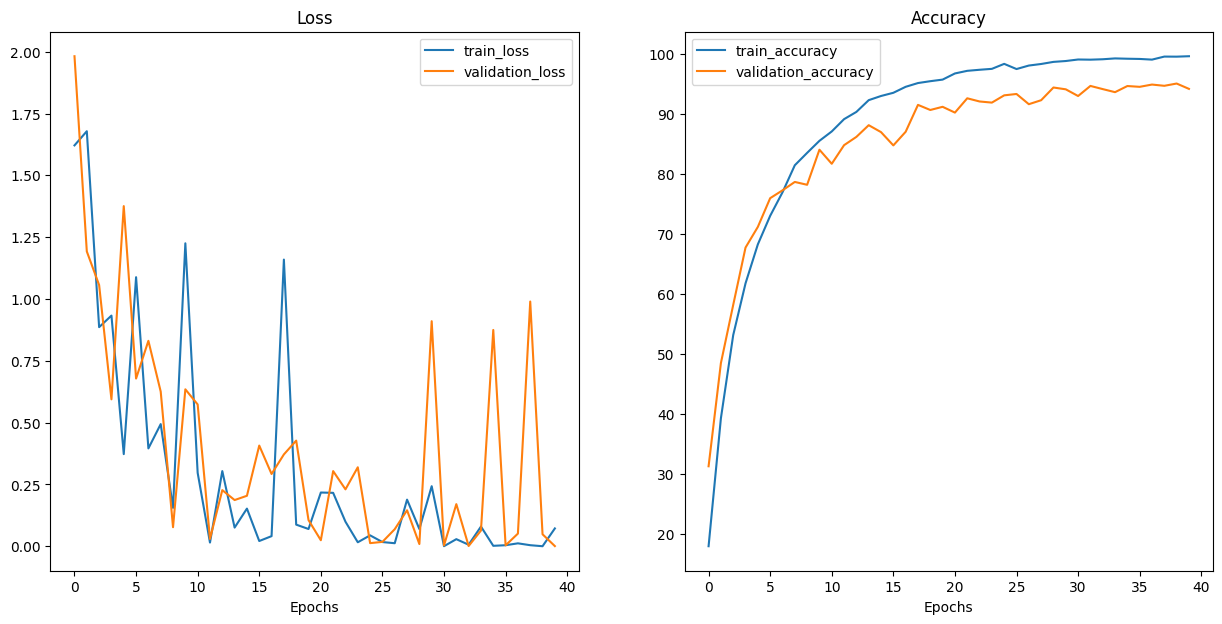

In [ ]:
plot_curves(resnet50_model_results)

**Load the model's state dict**

In [ ]:
model.load_state_dict(torch.load('/root/model.pt'))

<All keys matched successfully>

**Check the model's performance on test data**

In [ ]:
# Set the model to evaluation mode
model.eval()


# perform no gradient updates

with torch.no_grad():
    #for visualization and analysis
    test_acc = 0
    test_loss_list = []
    test_accuracy_list = []
    labels_list = []
    predictions_list = []
    # perform test set evaluation batch wise
    for (y, X) in test_dataloader:
        X, y = X.to(device), y.to(device)
        # append original labels
        labels_list.append(torch.argmax(y.view(8 * 8, 17), dim=1).data)

        # forward pass
        test_pred = model(X.view(-1, 3, 128, 128))

        # get argmax of predicted values, which is our label
        predicted = torch.argmax(test_pred, dim=1).data
        # append predicted label
        predictions_list.append(predicted)

        # calculate loss
        test_loss = loss_fn(test_pred.float(), torch.argmax(y.view(8 * 8, 17), dim=1).long())

        # calculate accuracy
        test_acc += (torch.argmax(test_pred, dim=1).data==torch.argmax(y.view(8 * 8, 17), dim=1)).sum()

        # append accuracy and losses for test samples
        test_accuracy_list.append(test_acc)
        test_loss_list.append(test_loss)

print(f"Test Loss: {test_loss_list[-1].item():.4f}")
print(f'Test accuracy: {test_accuracy_list[-1].item()*100/(672*8):.4f}%')

Test Loss: 0.0092
Test accuracy: 97.2842%


**Plot the Confusion Matrics to Visualize the predicitons**

In [ ]:
labels_list = torch.stack(labels_list)
predictions_list = torch.stack(predictions_list)


In [ ]:
class_names=get_classes(image_data_path)[0]
len(class_names)

17

In [ ]:
!pip install torchmetrics

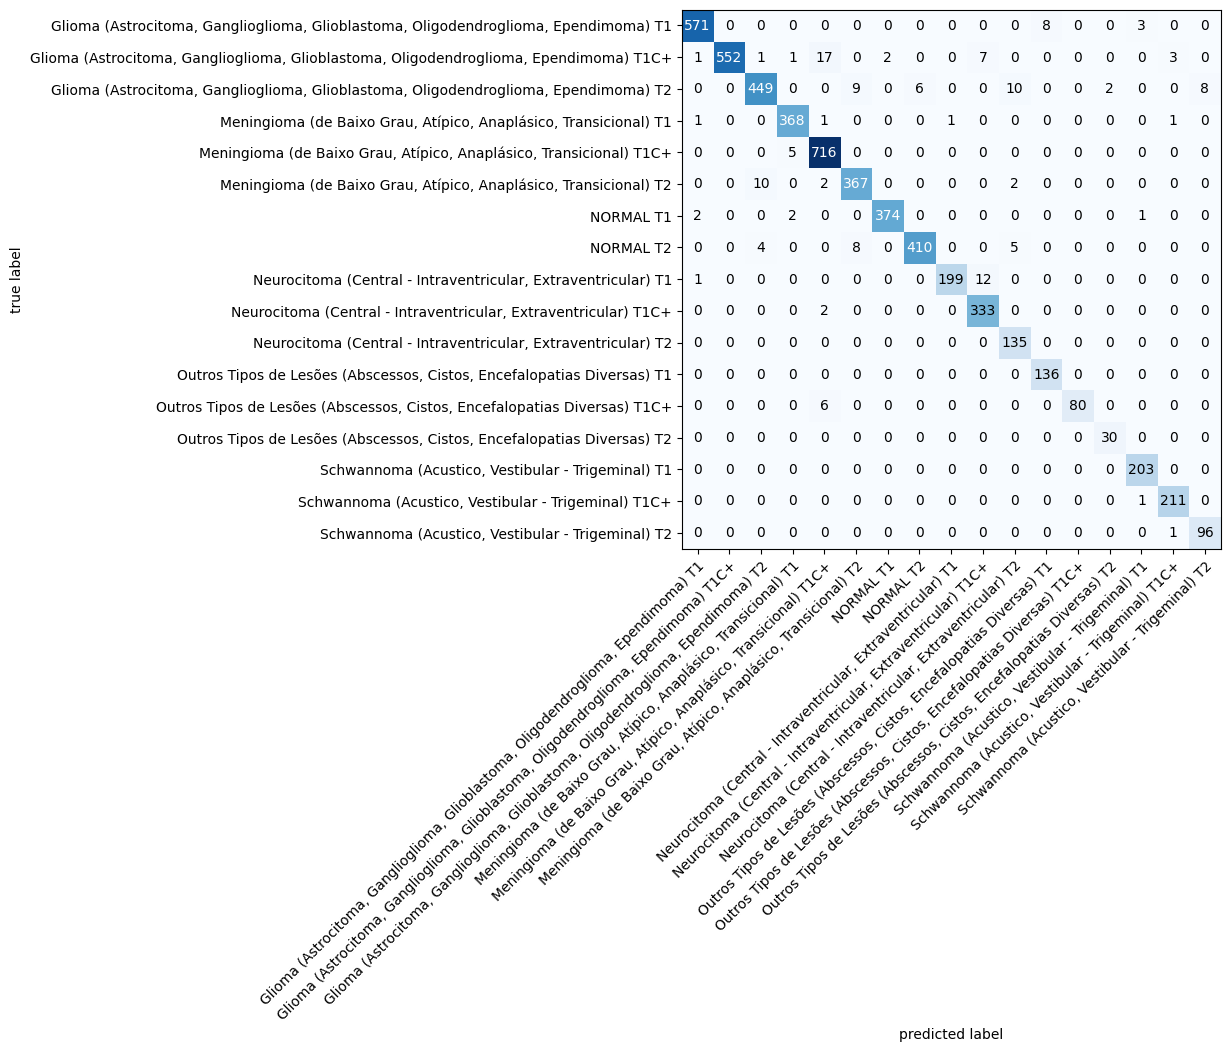

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=labels_list.cpu(),
                         target=predictions_list.cpu())

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);


**Prediction on Single Image**

In [ ]:
image_pth=Path("/content/images/image.jpeg")
image = Image.open(image_pth)
image = images_transform(image).unsqueeze(0).cuda()

In [ ]:
model.eval()

with torch.no_grad():
      # forward pass
      test_pred = model(image)
      print(test_pred.shape)

      # get argmax of predicted values, which is our label
      predicted = torch.argmax(test_pred).data
      print(predicted)

torch.Size([1, 17])
tensor(6, device='cuda:0')


In [ ]:
# Interpret the results
class_names = get_classes(image_data_path)[0]
predicted_class_idx = test_pred.argmax().item()
print(predicted_class_idx)
predicted_class_name = class_names[predicted_class_idx]
print(f"Predicted class: {predicted_class_name}")

6
Predicted class: NORMAL T1
